This project focuses on finding anomalies within a dataset. The dataset used is a measure of traffic data in Minneapolis in September of 2015. A couple of different models are utilized to attempt to detect anomalies.

The imports used in this project are used below:

In [179]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

The first step is to load the data into a panda data frame. This data comes from a CSV file hosted on GitHub, so the data is loaded from there. The loaded dataset is checked to ensure that the correct data is being worked with, and an array of data values is created for later.

In [180]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/occupancy_6005.csv', parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
data = df.values
df = df.set_index('timestamp')
df.head()

,value
timestamp,
2015-09-01 13:45:00,3.06
2015-09-01 13:50:00,6.44
2015-09-01 13:55:00,5.17
2015-09-01 14:00:00,3.83
2015-09-01 14:05:00,4.50


The first strategy utilized is using statistical quartiles to determine the outliers. The quartile Q2 is defined as the median of the data set (in this case, the values in the "value" column). Q1 is the median of the lower half of the values, and Q3 is the median of the upper half of the values.

In [181]:
arr = np.sort(df.values[:, 0])
size = int(len(arr)/2)
q1 = np.median(arr[:size])
q3 = np.median(arr[size:])
print(q1, q3)

1.94 6.17


The interquartile range is the difference between Q1 and Q3. This is important in determining the outliers. The outliers are defined as any value less than Q1 minus 1.5 times the interquartile range, or any value greater than Q3 plus 1.5 times the interquartile range. We can accumulate into a list any value that meets these criteria.

In [182]:
iqr = q3 - q1
lowerbound = q1 - 1.5 * iqr
upperbound = q3 + 1.5 * iqr
anomalies = [i for i in arr if i < lowerbound or i > upperbound]
print(anomalies)

[12.61, 12.72, 12.72, 12.78, 12.78, 12.78, 12.89, 13.0, 13.0, 13.11, 13.11, 13.28, 13.28, 13.28, 13.28, 13.28, 13.39, 13.39, 13.5, 13.56, 13.67, 13.78, 13.89, 13.89, 13.94, 13.94, 14.06, 14.17, 14.17, 14.17, 14.28, 14.28, 14.28, 14.33, 14.33, 14.44, 14.44, 14.44, 14.67, 14.67, 14.67, 14.78, 14.78, 14.83, 15.33, 15.33, 15.56, 15.61, 15.83, 15.94, 16.11, 16.33, 16.5, 16.61, 16.72, 16.78, 16.78, 16.78, 17.0, 17.11, 17.17, 17.39, 17.56, 17.56, 17.89, 17.94, 18.17, 18.33, 18.67, 18.83, 19.17, 21.11, 21.17, 22.28]


The values printed above are what are considered statistical outliers, or what could be classified as anomalies: values that do not fit within a general trend of data. This result was determined blindly, with no indications of what the data looks like visually or how it is distributed. As seen below, about three percent of the values are considered to be outliers.

In [183]:
print(100 * len(anomalies) / len(arr))

3.1092436974789917


However, determining if the data follows a particular distribution or trend can yield more sophisticated or more reliable results. When the data is plotted on a chart, this is what shows up:

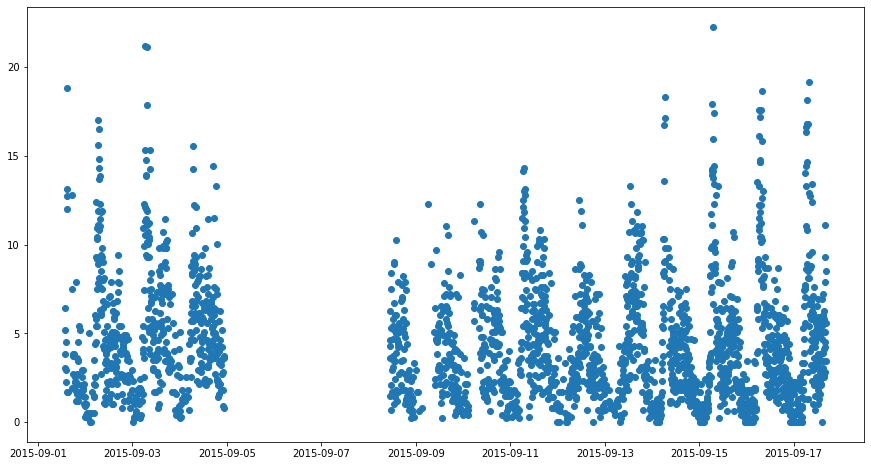

In [184]:
plt.figure(figsize=(15,8))
plt.plot(df, marker='o', ls='')

In the chart above, clear groupings of data points can be distinguished. Fourteen of them, in fact. Anomalies are clearly visible toward the top of the graph. These groupings could be considered "clusters" of data points, so a clustering algorithm might be a more sophisticated way of deterimining which of these points are outliers.

A popular clustering algorithm is KMeans. To use it effectively, the date values need to be converted to integer values. Using Python 3 datetime tools, the dates can be converted to seconds since the first data point was recorded, and then consolidated into smaller, more readable values.

In [185]:
temp = data[:, 0]
epoch = datetime.datetime.utcfromtimestamp(1441115100)
temp = [(i - epoch).total_seconds() / 100 for i in temp]
data[:, 0] = temp
model = KMeans(n_clusters=14, random_state=5)
y = model.fit_predict(data)

Now the data is ready to be visualized.

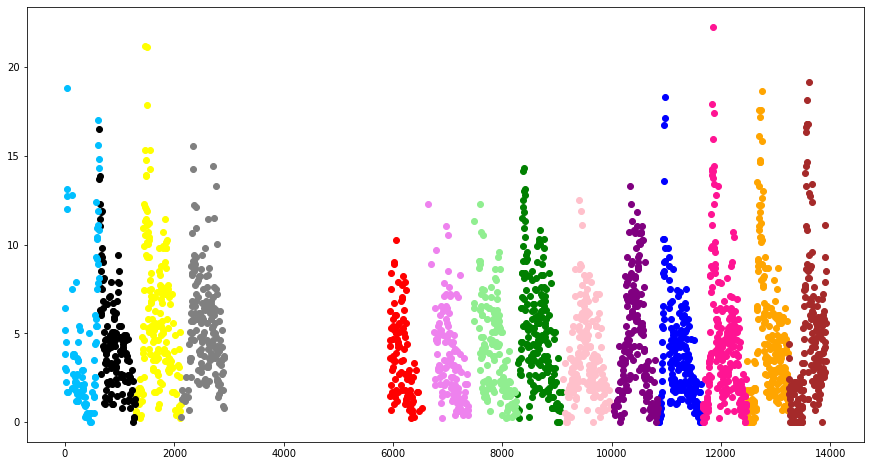

In [186]:
plt.figure(figsize=(15,8))
for i, color in enumerate(['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'brown', 'black', 'gray', 'pink', 'lightgreen', 'deepskyblue', 'purple', 'deeppink']):
    plt.scatter(data[y == i, 0], data[y == i, 1], c=color)
plt.show()

Each cluster of data points has a particular cluster center that the data points are matched to based on their proximity. In this format, anomalies can be detected on a per-cluster basis instead of as a whole.

In [187]:
center = model.cluster_centers_
print(center)

[[6.16100400e+03 3.68990000e+00]
 [1.28716987e+04 4.53351111e+00]
 [1.67840000e+03 5.86028249e+00]
 [8.65641515e+03 5.14000000e+00]
 [1.12603405e+04 3.63502439e+00]
 [7.04045854e+03 3.64943089e+00]
 [1.36019538e+04 4.35846154e+00]
 [9.03626277e+02 4.65233577e+00]
 [2.56065698e+03 5.39546512e+00]
 [9.53464972e+03 3.72397790e+00]
 [7.86403490e+03 4.04328859e+00]
 [3.44719149e+02 4.81670213e+00]
 [1.04449348e+04 4.63971910e+00]
 [1.20624283e+04 4.43472103e+00]]


The data points in each respective cluster have their distances recorded. Each point a certain distance away from a cluster center is considered an anomaly. To print the eight values furthest away from their cluster centers in each cluster, for example:

In [188]:
for i in range(14):
    x_coords, y_coords = data[y == i, 0], data[y == i, 1]
    distances = []
    for x0, y0 in zip(x_coords, y_coords):
        distances += [[math.sqrt((x0 - center[i, 0]) ** 2 + (y0 - center[i, 1]) ** 2), y0]]
    print(np.sort(distances, axis=0)[-8:, 1])

[ 7.72  7.89  7.89  8.22  8.39  8.89  9.   10.28]
[14.67 14.78 15.83 16.11 17.17 17.56 17.56 18.67]
[13.94 14.28 14.78 15.33 15.33 17.89 21.11 21.17]
[11.83 12.11 12.5  12.78 13.   13.11 14.17 14.33]
[ 9.83  9.83 10.33 10.33 13.56 16.72 17.11 18.33]
[ 7.83  8.28  8.5   8.89  9.67 10.56 11.06 12.28]
[14.67 16.33 16.61 16.78 16.78 16.78 18.17 19.17]
[11.06 11.44 11.83 11.89 12.28 13.67 13.89 16.5 ]
[11.44 11.5  12.11 12.22 13.28 14.28 14.44 15.56]
[ 8.28  8.61  8.61  8.78  8.89 11.11 11.89 12.5 ]
[ 9.06  9.06  9.28  9.56 10.56 10.72 11.33 12.28]
[12.72 12.78 13.11 14.33 14.83 15.61 17.   18.83]
[10.72 10.83 11.06 11.06 11.33 11.83 12.28 13.28]
[14.17 14.17 14.28 14.44 15.94 17.39 17.94 22.28]
